In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
import glob

def filtering_func_1(freqs, ffts, all_phases, f1, f2): #passing 2D complex matrix as ffts
    noise_ffts = ffts.copy() #!!!
    
    #average the rows
    avg_fft = np.mean(np.abs(ffts), axis = 0)
    avg_phases = np.mean(all_phases, axis = 0)
    valid_indices = np.where((freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1))[0]

    fft_in_range = avg_fft[valid_indices]

    peak = np.max(fft_in_range)

    local_peak_indices = np.where(avg_fft[valid_indices] == peak)[0]
    general_peak_indices = valid_indices[local_peak_indices]

    peak_f = freqs[general_peak_indices]
    print(f"peak_f: {peak_f}")

    peak_phase = avg_phases[general_peak_indices]
    print(f"peak_phase: {peak_phase}")

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    mask = np.ones(noise_ffts.shape, dtype=bool)
    mask[:, general_peak_indices] = False #!!!
    noise_ffts[mask] = complex(0, 0) #!!!
    return noise_ffts, peak_f, peak_phase

In [17]:
hour = '15.42'
day = '08082024'

In [18]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        print(df)
        if i == 0:
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)

              Time    Channel D
0             (us)         (mV)
1       0.00000000  -1.96850400
2       0.00080000  -1.57480300
3       0.00160000  -1.18110200
4       0.00240000  -0.78740150
...            ...          ...
62500  49.99920067   0.00000000
62501  50.00000067   0.39370070
62502  50.00080067  -0.39370070
62503  50.00160067  -1.18110200
62504  50.00240067  -1.18110200

[62505 rows x 2 columns]
              Time    Channel D
0             (us)         (mV)
1       0.00000000   1.57480300
2       0.00080000   0.78740150
3       0.00160000   0.00000000
4       0.00240000   0.00000000
...            ...          ...
62500  49.99920067   1.57480300
62501  50.00000067   0.78740150
62502  50.00080067  -0.39370070
62503  50.00160067  -2.75590500
62504  50.00240067  -4.72440900

[62505 rows x 2 columns]
              Time    Channel D
0             (us)         (mV)
1       0.00000000  -0.39370070
2       0.00080000  -0.39370070
3       0.00160000   0.39370070
4       0.00240000  

In [19]:
N = len(times)
print(f"len(times): {N}")
print(f"{times}")

len(times): 62504
[0.00000000e+00 8.00000000e-04 1.60000000e-03 ... 5.00008007e+01
 5.00016007e+01 5.00024007e+01]


## FFT

In [20]:
span = times[-1]
print(f"span: {span}") 
step = span / N
f_s = 1 / step
print(f"f_s = {f_s}")

freqs = fft.fftfreq(N, 1/f_s) #window lenght, sample spacing
print(f"last freq: {freqs[-1]}") #this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")
print(freqs)

span: 50.00240067
f_s = 1250.0199822905824
last freq: -0.019999039778103522
len(freqs): 62504
[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]


In [21]:
all_magnitudes = fft.fft(all_amplitudes, axis = 1) 
all_phases = np.angle(all_magnitudes)

In [22]:
avg_fft = np.mean(np.abs(all_magnitudes), axis = 0) #!!!
n = np.max(avg_fft)

avg_phases = np.mean(all_phases, axis = 0)

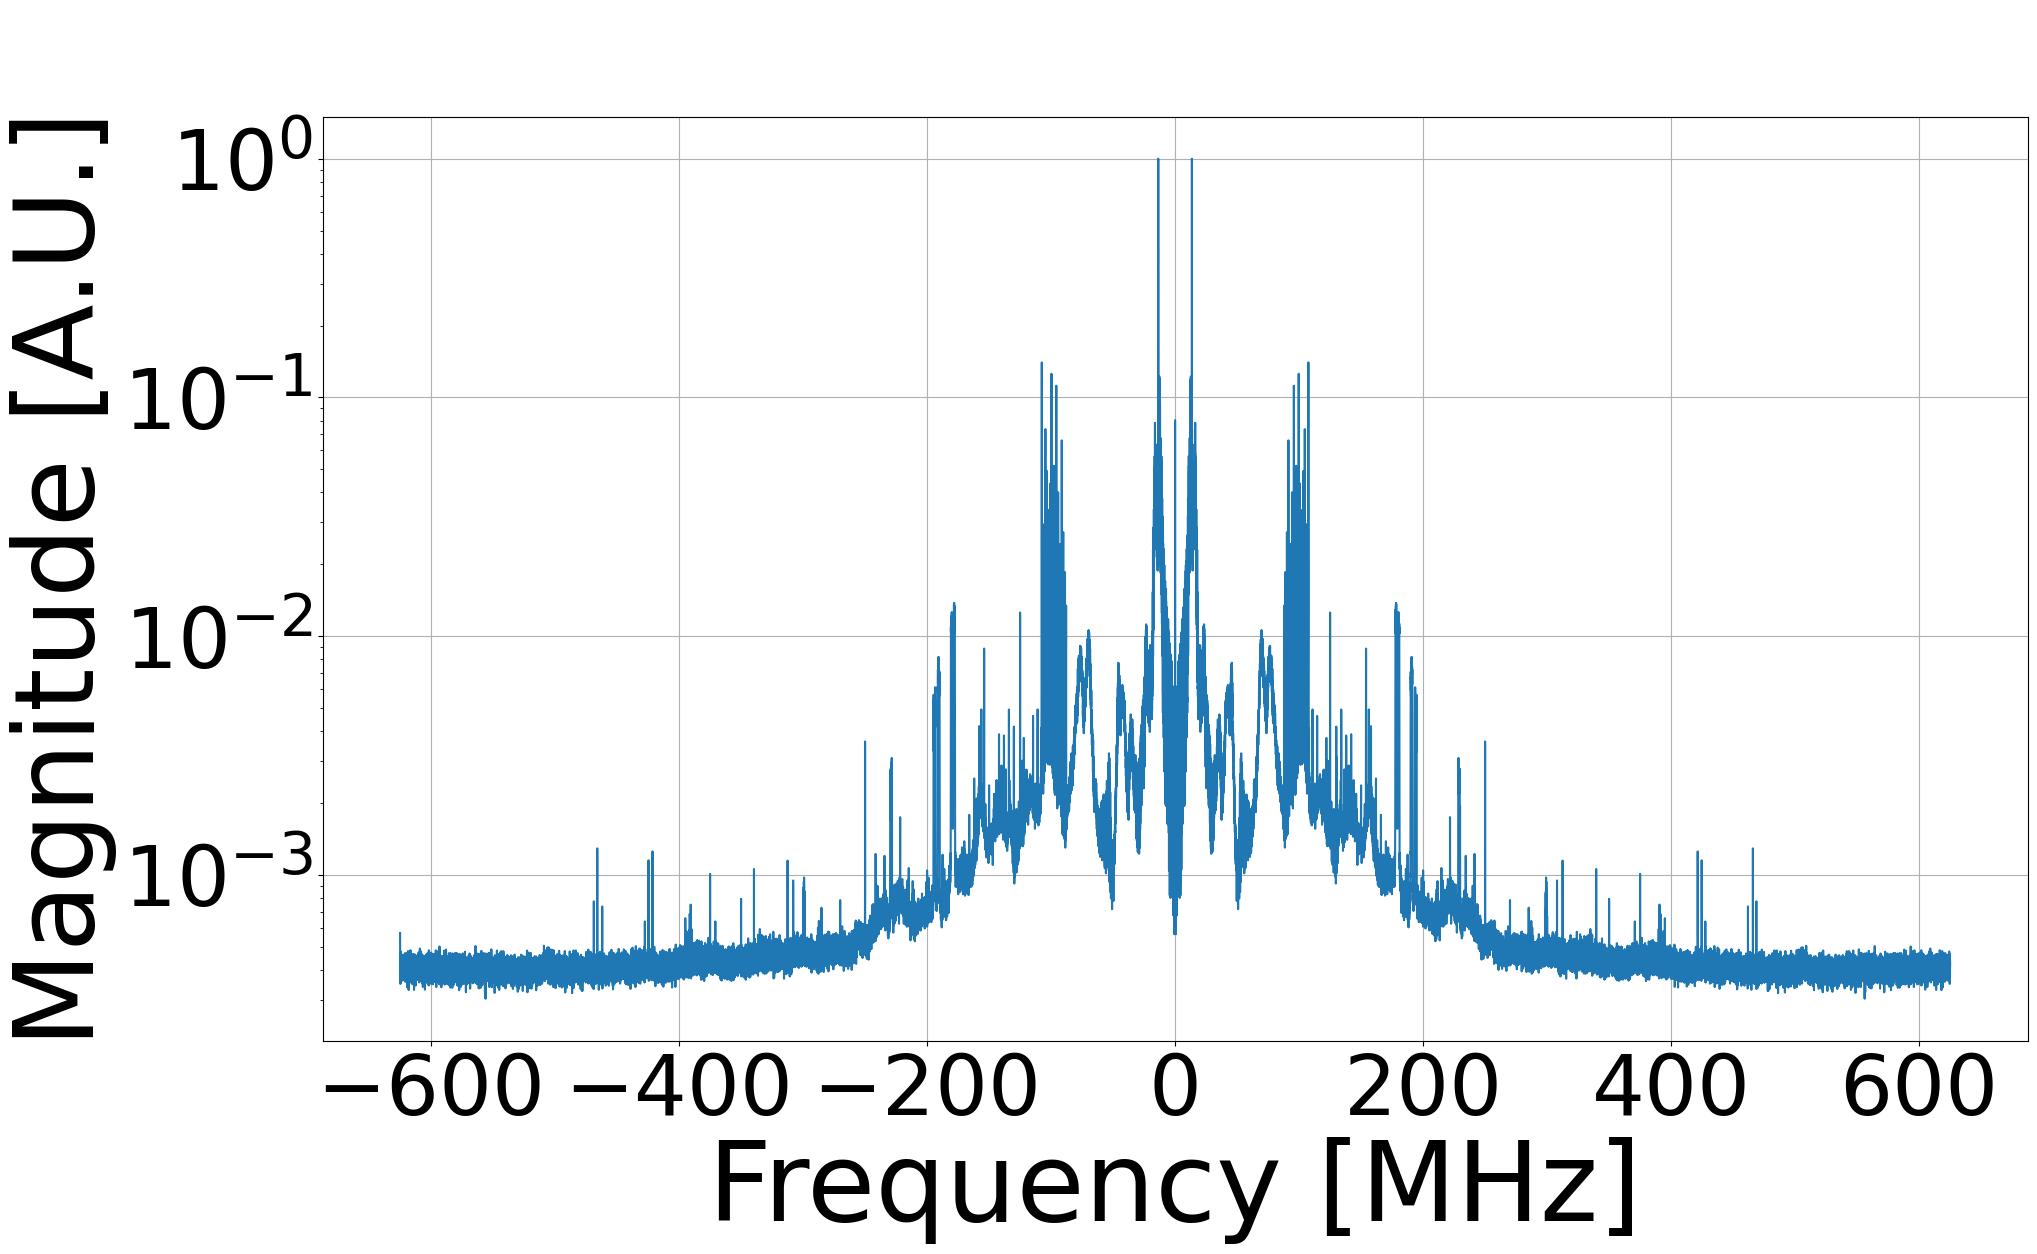

In [23]:
freqs_shifted = fft.fftshift(freqs)
avg_fft_shifted = fft.fftshift(avg_fft)

plt.figure(figsize=(22, 12))
plt.plot(freqs_shifted, avg_fft_shifted/n)

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.semilogy()
plt.grid(True)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [24]:
if (N%2 == 0):
    pos_freqs = freqs[:round((N/2))]
    pos_avg_fft = avg_fft[:round((N/2))]
    pos_avg_phases = avg_phases[:round((N/2))]
else:
    pos_freqs = freqs[:round((N-1)/2 + 1)]
    pos_avg_fft = avg_fft[:round((N-1)/2 + 1)]
    pos_avg_phases = avg_phases[:round((N-1)/2 + 1)]

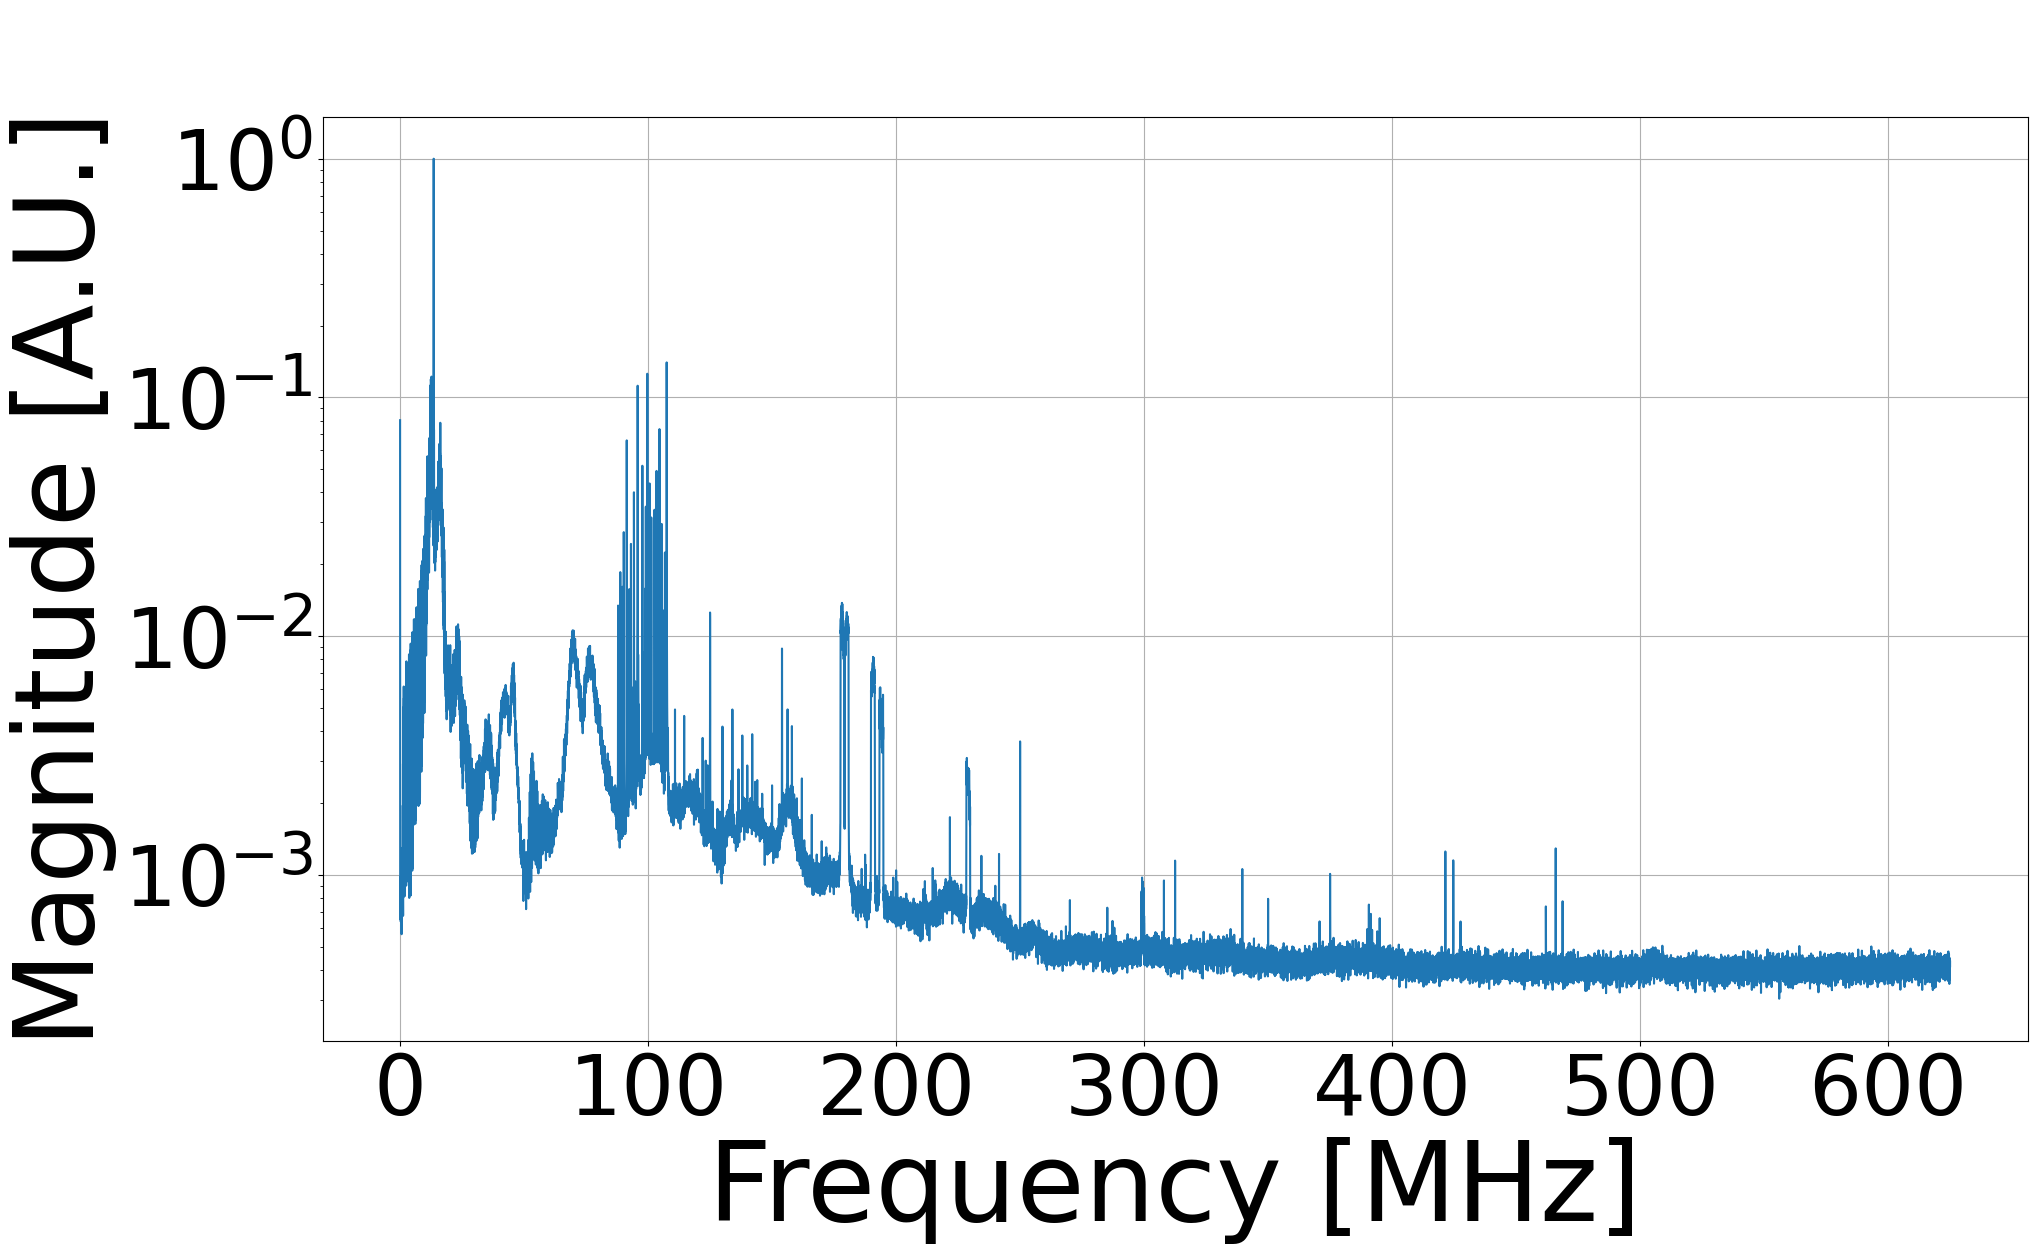

In [25]:
plt.figure(figsize=(22, 12))
plt.plot(pos_freqs, np.abs(pos_avg_fft)/n)

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.semilogy()
plt.grid(True)

#plt.savefig("../Results/080824_15.42/fft_zoom.pdf", format = "pdf", bbox_inches="tight")
plt.show()

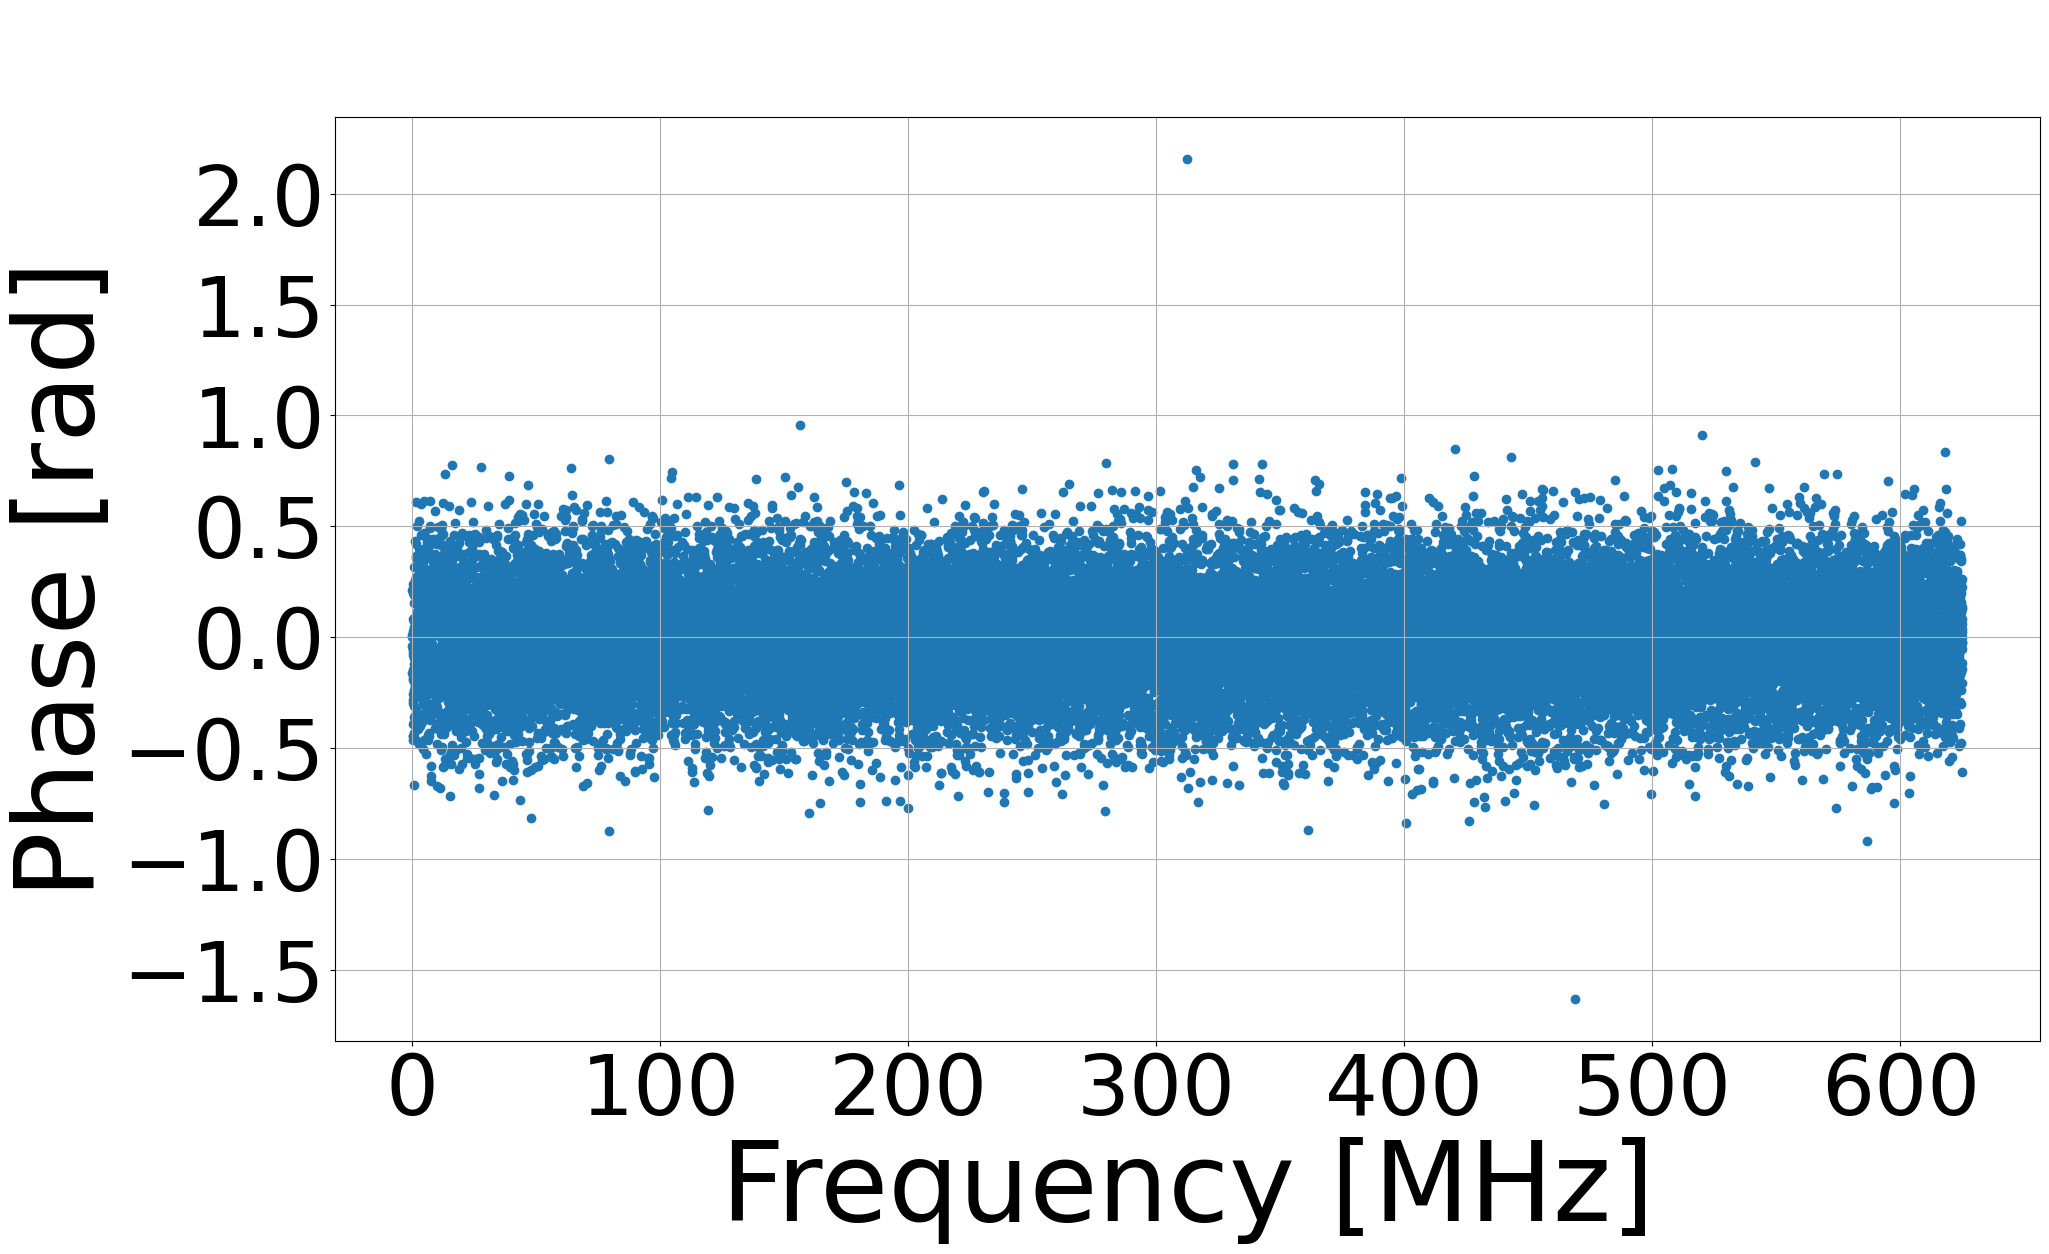

In [26]:
plt.figure(figsize=(22, 12))
plt.scatter(pos_freqs, pos_avg_phases)

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Phase [rad]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)

#plt.savefig("../Results/080824_15.42/right_phases.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [27]:
f1 = 13
f2 = 14

In [28]:
print(f"positive peak frequency: {pos_freqs[(pos_freqs >= f1) & (pos_freqs <= f2)][np.argmax(pos_avg_fft[(pos_freqs <= f2) & (pos_freqs >= f1)])]} Hz")
print(f"positive peak phase: {pos_avg_phases[(pos_freqs >= f1) & (pos_freqs <= f2)][np.argmax(pos_avg_fft[(pos_freqs <= f2) & (pos_freqs >= f1)])]*180/np.pi} deg")

positive peak frequency: 13.559348969554188 Hz
positive peak phase: 21.62065859970982 deg


## Filtering

In [29]:
noise_ffts, peak_f, peak_phases = filtering_func_1(freqs, all_magnitudes, all_phases, f1, f2)
avg_noise_fft = np.mean(np.abs(noise_ffts), axis = 0)

peak_f: [ 13.55934897 -13.55934897]
peak_phase: [ 0.37735168 -0.37735168]
sum: 2


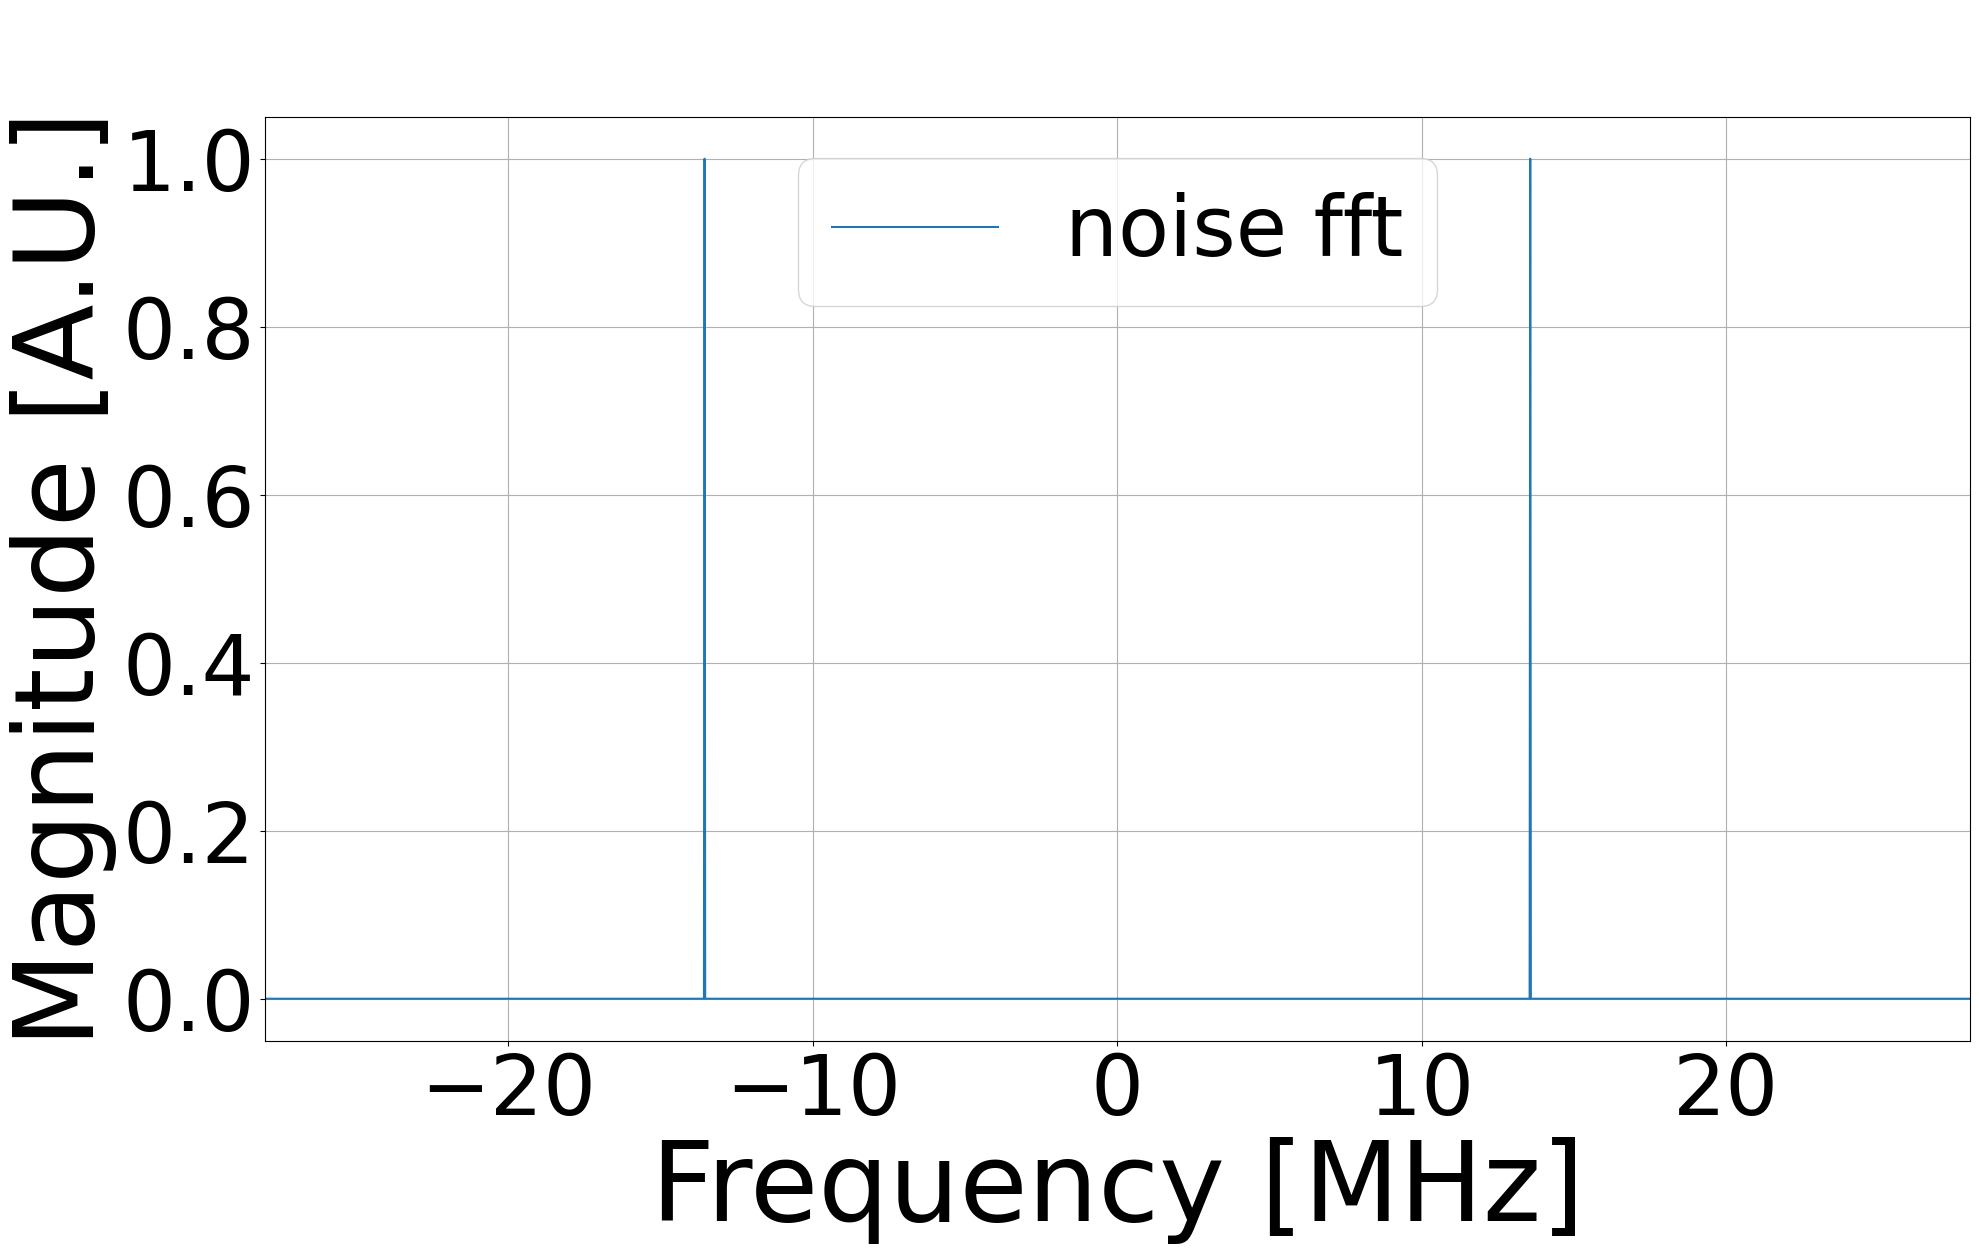

In [44]:
avg_noise_fft_shifted = fft.fftshift(avg_noise_fft)

plt.figure(figsize=(22, 12))
plt.plot(freqs_shifted, avg_noise_fft_shifted/n, label = 'noise fft')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.xlim(-f2*2, f2*2)
plt.grid(True)
plt.legend(fontsize = 60)

#plt.savefig("../Results/080824_15.42/method2_noise_fft_test1.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method2_noise_fft_test1.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [31]:
reconstructed_noise_wf = fft.ifft(avg_noise_fft)

In [32]:
A = max(reconstructed_noise_wf.real)
f = peak_f[0]
phi = peak_phases[0]
coswave = A*np.cos(f*np.pi*2*times + phi)

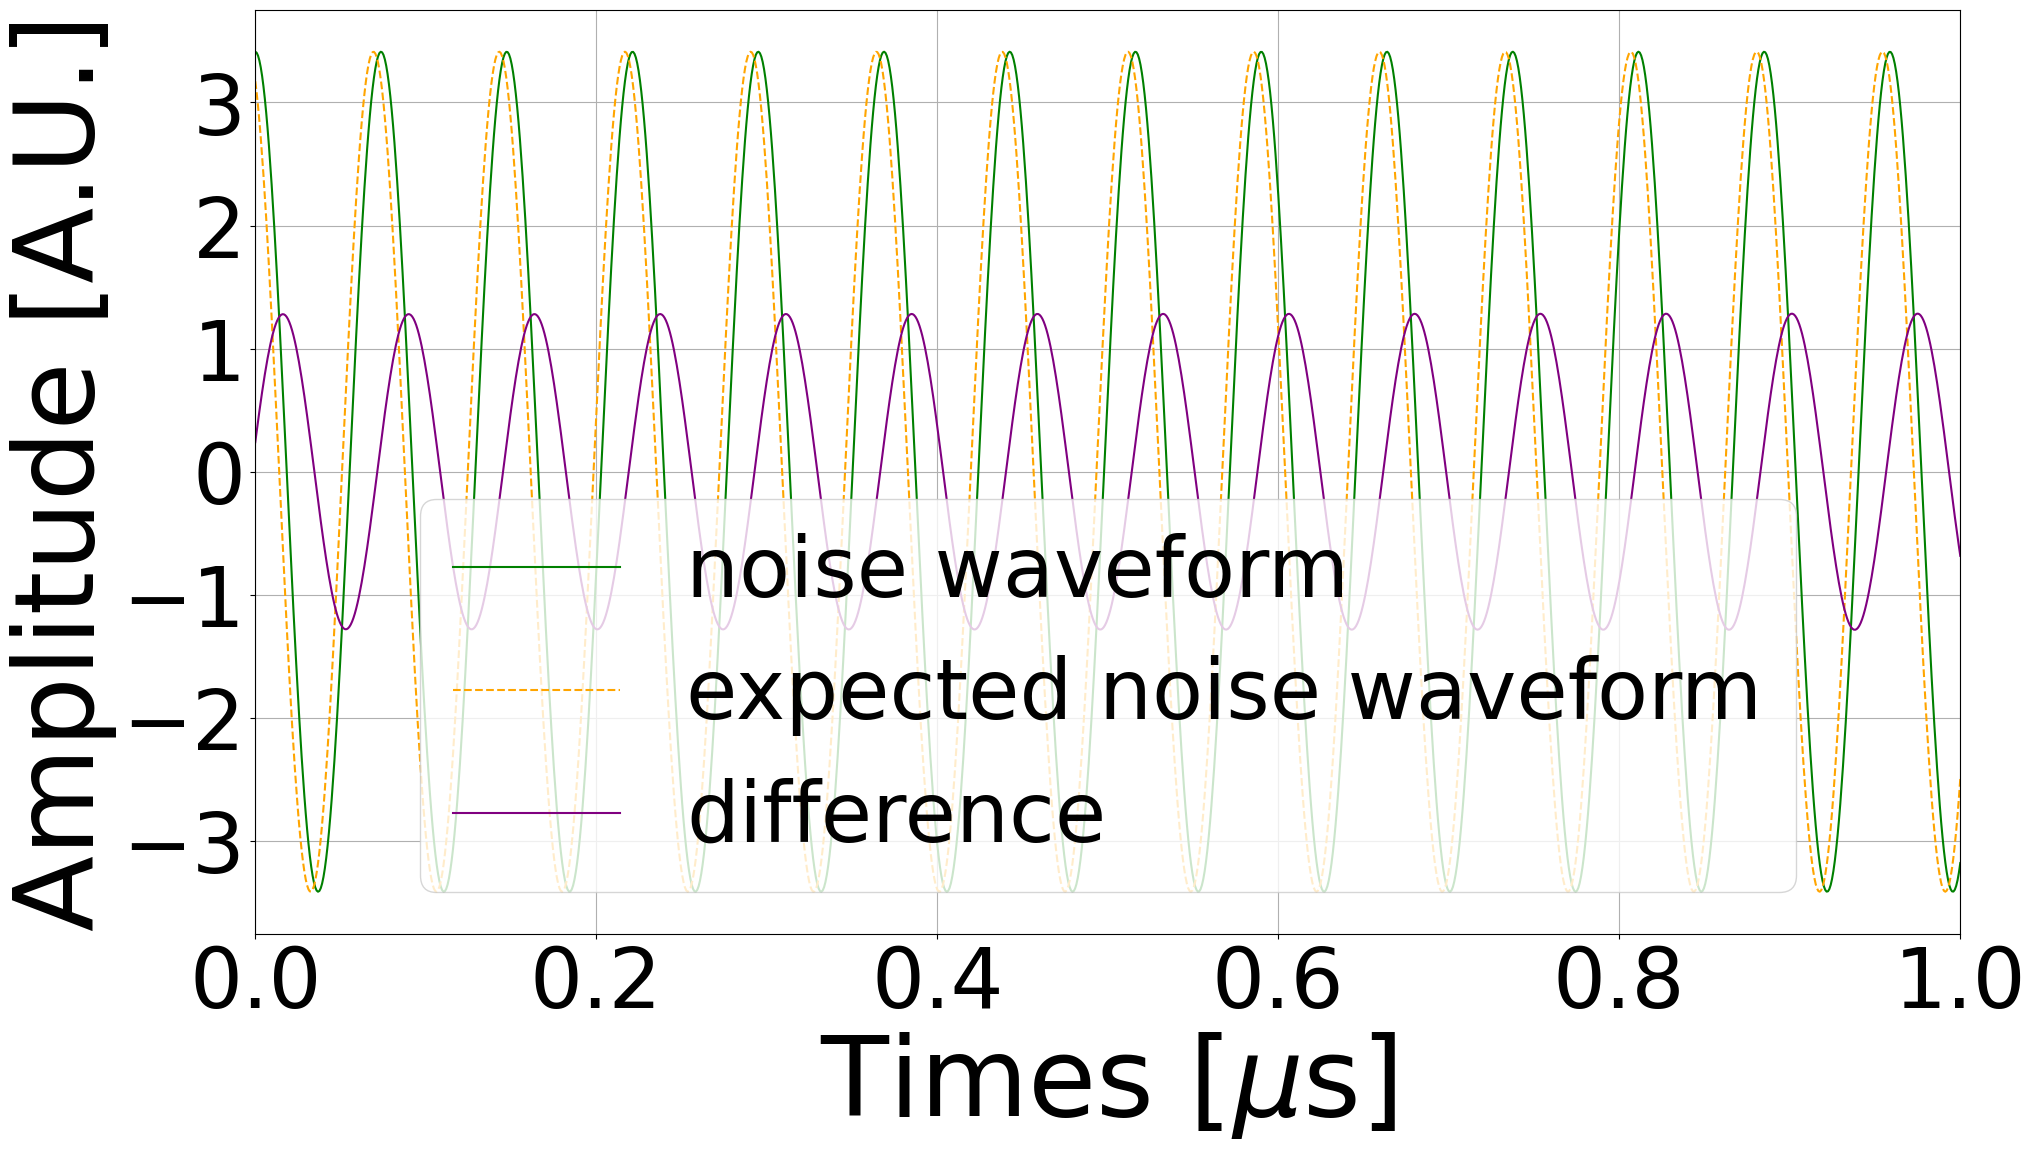

In [43]:
plt.figure(figsize=(22, 12))
plt.plot(times, reconstructed_noise_wf.real, color = 'green', label = 'noise waveform') #you can see that it remembers the phase only if you pass the complex numbers as fft to fft.ifft
plt.plot(times, coswave, linestyle = '--', color = 'orange', label = 'expected noise waveform')
plt.plot(times, reconstructed_noise_wf.real - coswave, color = 'purple', label = 'difference')

plt.title('', fontsize = 80)
plt.xlabel(r'Times [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'lower center', fontsize = 60)

plt.savefig("../Results/080824_15.42/method2_noise_wf_test1.png", format = "png", bbox_inches="tight")
plt.savefig("../Results/080824_15.42/method2_noise_wf_test1.pdf", format = "pdf", bbox_inches="tight")
plt.show()


In [34]:
print(np.arccos((reconstructed_noise_wf.real)[times == 0]/A)*180/np.pi)
print(np.arccos((coswave)[times == 0]/A)*180/np.pi)

[0.]
[21.6206586]


## Compare to reconstructed waveform

In [35]:
reconstructed_wf = fft.ifft(avg_fft)

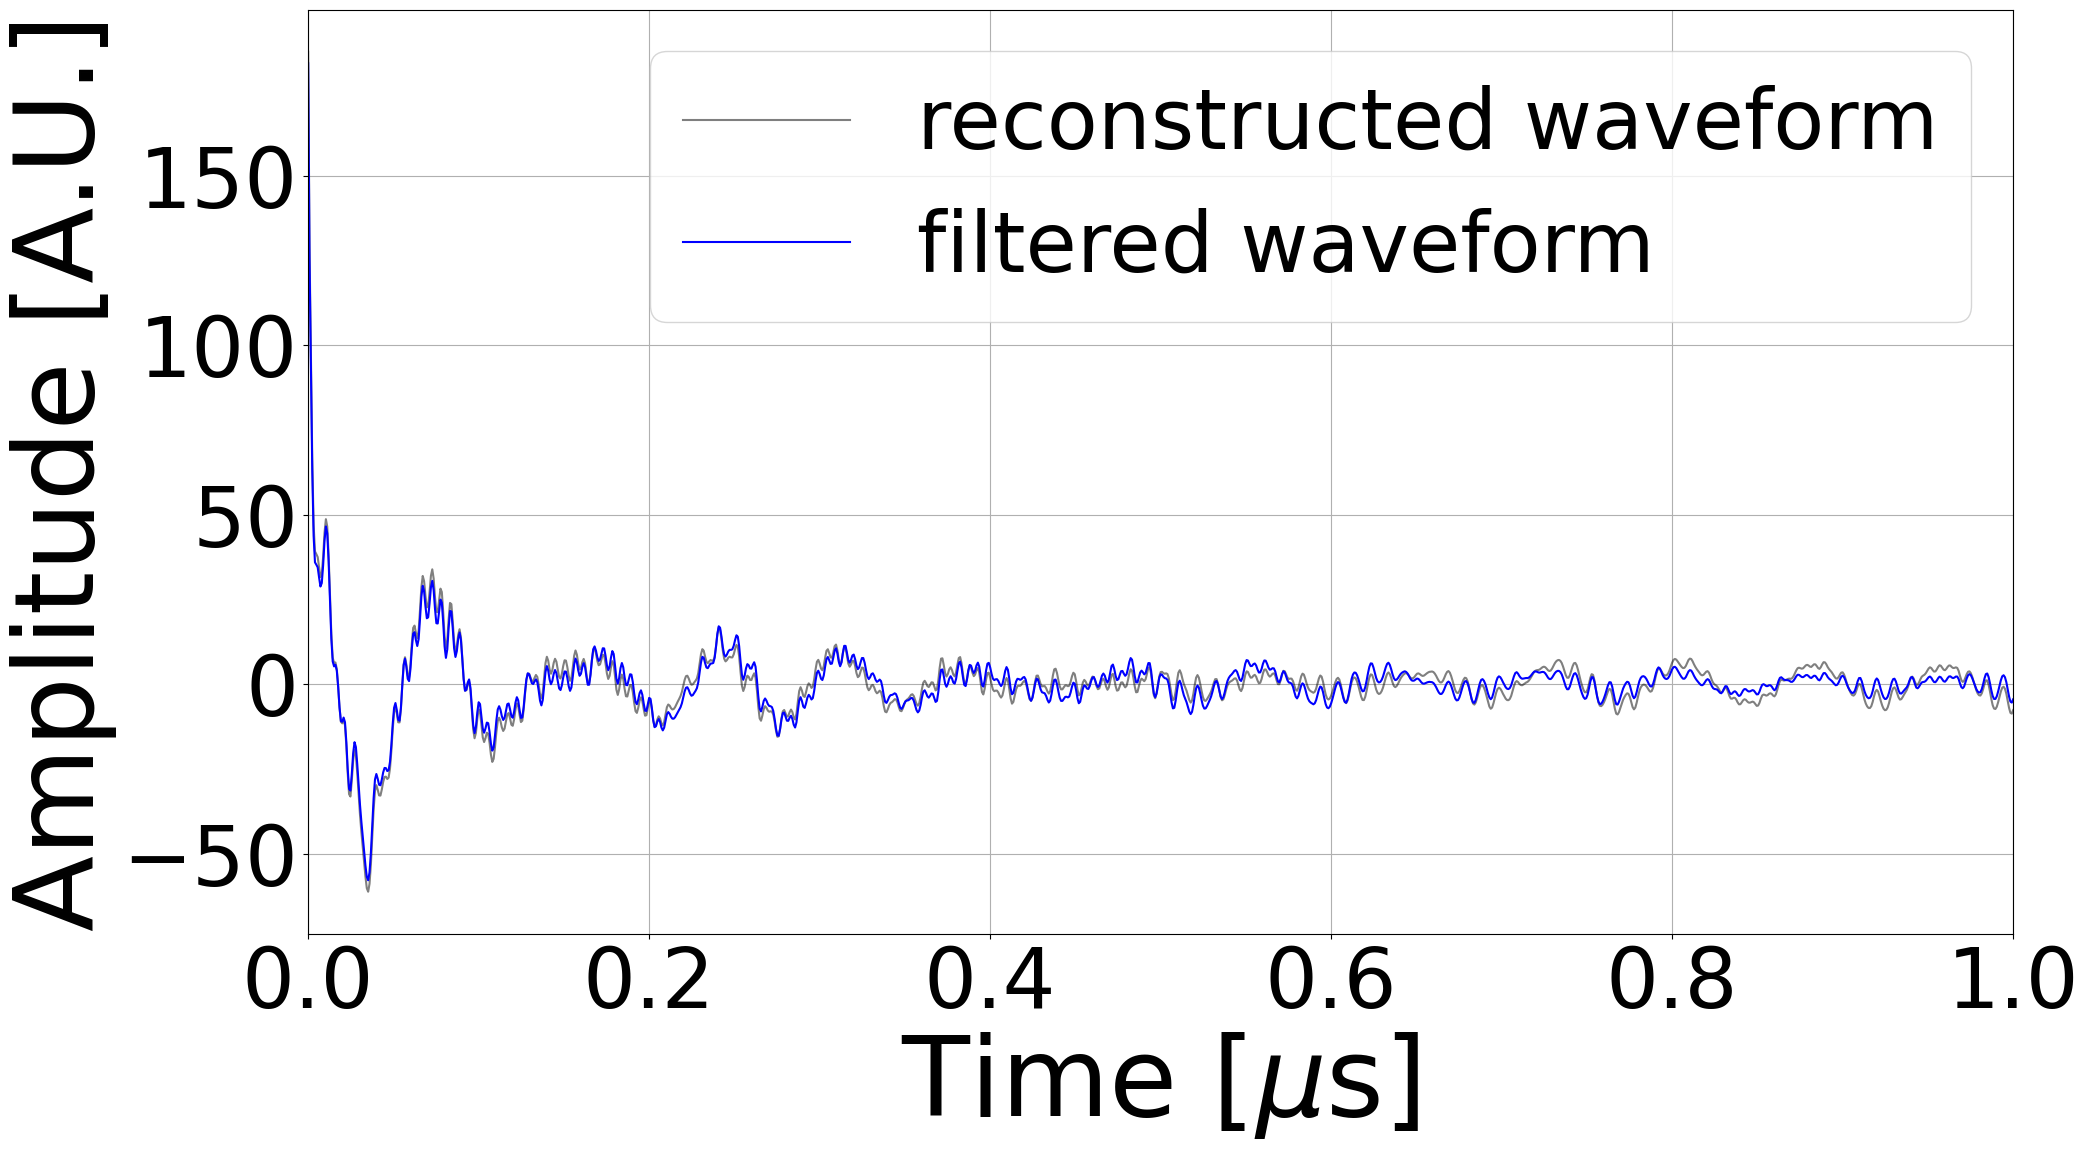

In [36]:
plt.figure(figsize = (22, 12))
plt.plot(times, reconstructed_wf.real, label = 'reconstructed waveform', color = 'black', alpha = 0.5)
plt.plot(times, reconstructed_wf.real - reconstructed_noise_wf.real, label = 'filtered waveform', color = 'blue')

plt.title('', fontsize = 80)
plt.xlabel(r'Time [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 60)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("../Results/080824_15.42/method2_filtered_wf_test1.pdf", format = "pdf", bbox_inches="tight")
plt.show()

# Plot reconstructed FFT

In [37]:
avg_filtered_wf = reconstructed_wf - reconstructed_noise_wf

In [38]:
avg_filtered_fft = fft.fft(avg_filtered_wf)

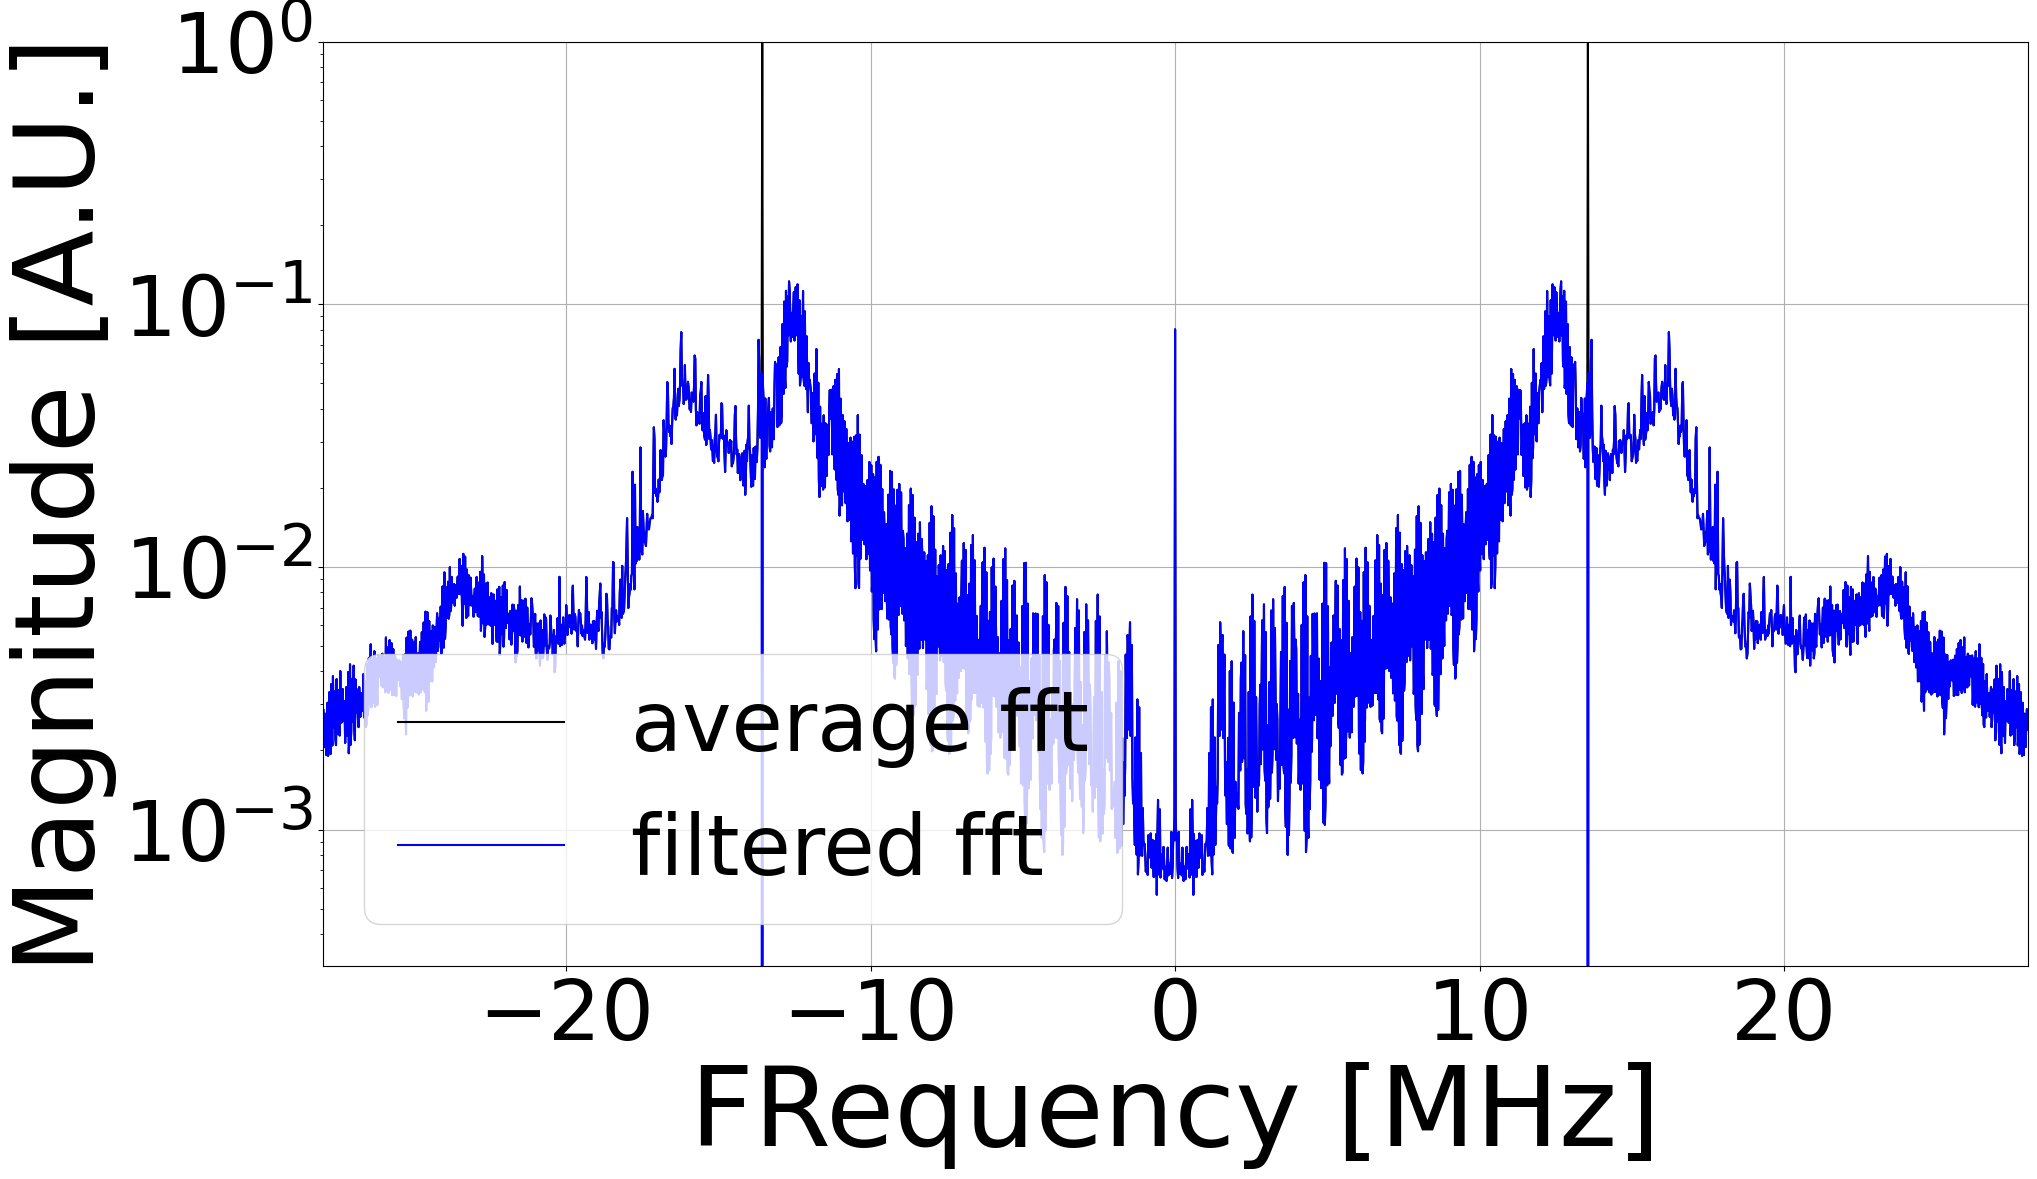

In [39]:
avg_filtered_fft_shifted = fft.fftshift(avg_filtered_fft)

plt.figure(figsize = (22, 12))
plt.plot(freqs_shifted, np.abs(avg_fft_shifted)/n, color = 'k', label = 'average fft')
plt.plot(freqs_shifted, np.abs(avg_filtered_fft_shifted)/n, color = 'blue', label = 'filtered fft')

plt.title('', fontsize = 80)
plt.xlabel('FRequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.semilogy()
plt.ylim([min(np.abs(avg_fft_shifted)/n), max(np.abs(avg_fft_shifted)/n)])  # Adjust the y-axis range
plt.xlim(-f2*2, f2*2)
plt.legend(loc = 'lower left',fontsize = 60)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [40]:
if (N%2 == 0):
    pos_avg_filtered_fft = avg_filtered_fft[:round((N/2))]
else:
    pos_avg_filtered_fft = avg_filtered_fft[:round((N-1)/2 + 1)]

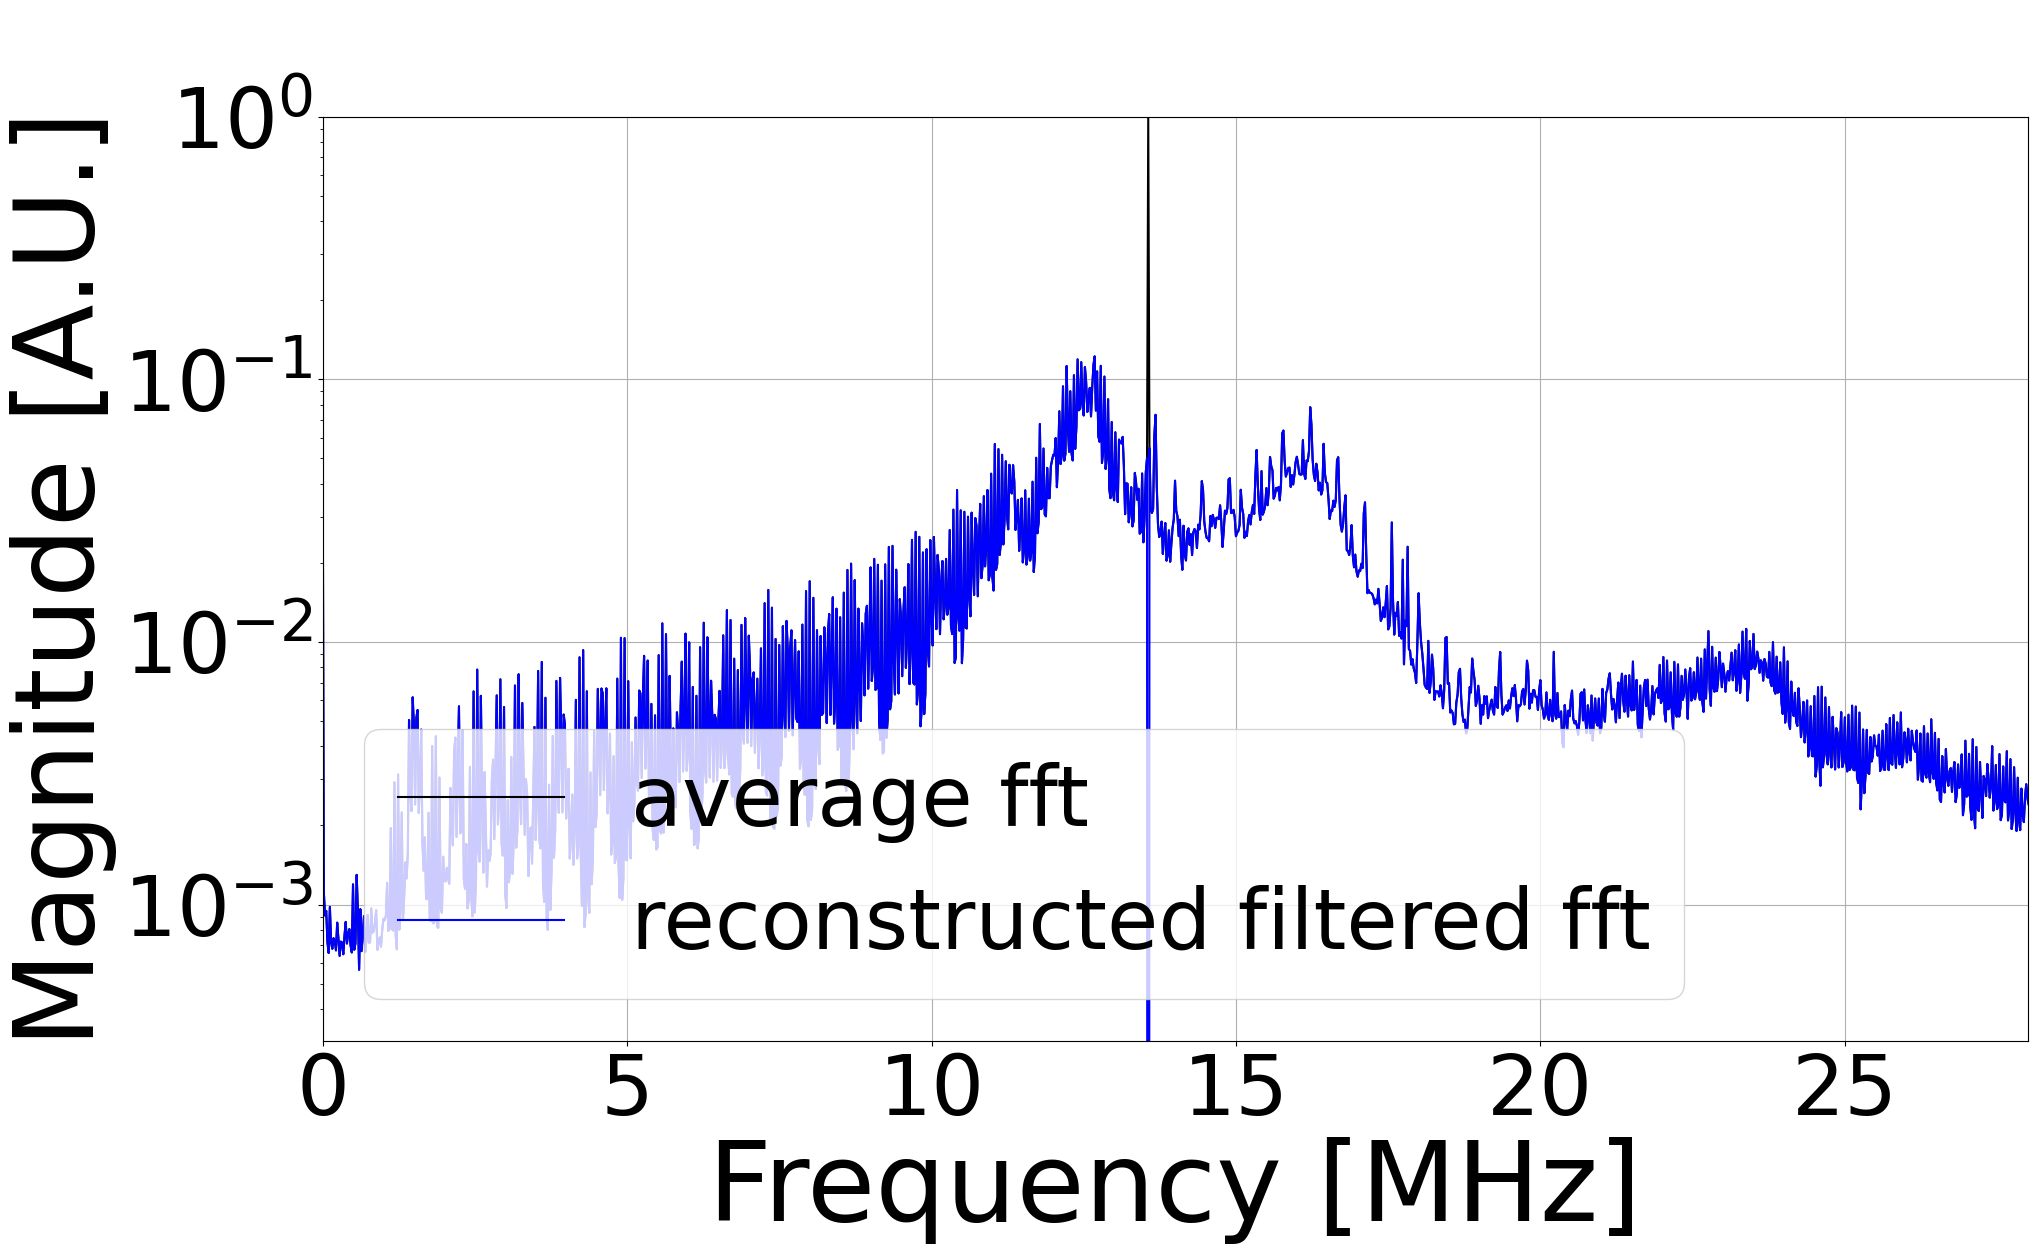

In [41]:
plt.figure(figsize=(22, 12))
plt.plot(pos_freqs, np.abs(pos_avg_fft)/n, color = 'k', label = 'average fft')
plt.plot(pos_freqs, np.abs(pos_avg_filtered_fft)/n, color = 'blue', label = 'reconstructed filtered fft')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, f2*2)
plt.ylim([min(np.abs(pos_avg_fft)/n), max(np.abs(pos_avg_fft)/n)])  # Adjust the y-axis range
plt.legend(loc = 'lower left', fontsize = 60)
plt.semilogy()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()